### DATA 설명

#### 1. ip: ip address of click
#### 2. app: app id for marketing
#### 3. device: device type id of user mobile phone (e.g., iphone 6 plus, iphone 7, huawei mate 7, etc.)
#### 4. os: os version id of user mobile phone
#### 5. channel: channel id of mobile ad publisher
#### 6. click_time: timestamp of click (UTC)
#### 7. attributed_time: if user download the app for after clicking an ad, this is the time of the app download
#### 8. is_attributed: the target that is to be predicted, indicating the app was downloaded

### 라이브러리

In [2]:
# 라이브러리
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import time
import numpy as np
# from sklearn.cross_validation import train_test_split
# import xgboost as xgb
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set(style='ticks')
color = sns.color_palette()
# import datetime
# import time

In [1]:
import xgboost as xgb

### 데이터 타입

In [3]:
# 데이터 타입 
start_time = time.time()

dtypes = {
        'ip':'uint32',
        'app': 'uint16',
        'device': 'uint16',
        'os': 'uint16',
        'channel': 'uint16',
        'is_attributed': 'uint8'
        }

train = pd.read_csv("./data/train.csv", dtype = dtypes)
train.columns = ['ip', 'app', 'device', 'os', 'channel', 'click_time', 'attributed_time', 'is_attributed']
test = pd.read_csv("./data/test.csv")

print('[{}] Finished to load data'.format(time.time() - start_time))

[127.54818773269653] Finished to load data


### EDA

In [5]:
# 상위 10개
train.head(n = 10)

,ip,app,device,os,channel,click_time,attributed_time,is_attributed
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0
5,18787,3,1,16,379,2017-11-06 14:36:26,NaN,0
6,103022,3,1,23,379,2017-11-06 14:37:44,NaN,0
7,114221,3,1,19,379,2017-11-06 14:37:59,NaN,0
8,165970,3,1,13,379,2017-11-06 14:38:10,NaN,0
9,74544,64,1,22,459,2017-11-06 14:38:23,NaN,0


In [6]:
# 데이터 정보 (5.0 GB) / R보다 느린듯
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 184903890 entries, 0 to 184903889
Data columns (total 8 columns):
ip                 uint32
app                uint16
device             uint16
os                 uint16
channel            uint16
click_time         object
attributed_time    object
is_attributed      uint8
dtypes: object(2), uint16(4), uint32(1), uint8(1)
memory usage: 5.0+ GB


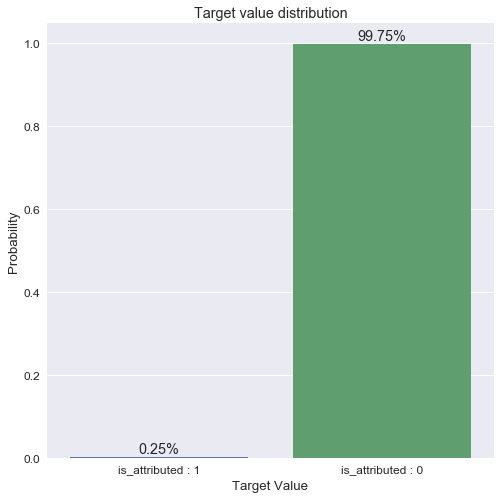

In [18]:
# 불균형 문제
# 0 : 99.75 %
# 1 : 0.25 %
plt.figure(figsize=(8, 8))
sns.set(font_scale=1.2)
mean = (train.is_attributed.values == 1).mean()
ax = sns.barplot(['is_attributed : 1', 'is_attributed : 0'], [mean, 1 - mean], palette = color)
ax.set(xlabel='Target Value', ylabel='Probability', title='Target value distribution')
for p, uniq in zip(ax.patches, [mean, 1-mean]):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 0.01,
            '{}%'.format(round(uniq * 100, 2)),
            ha="center") 

In [165]:
(train.is_attributed.values == 1).mean()

0.0024707214109989791

In [ ]:
# train 전체 ip 값 고유개수는 277,396

In [166]:
# 245,038 개
len(train[train.is_attributed == 1].groupby('ip').size())

ip
1         9
6         2
9         6
10        3
19        4
20        4
25        2
27        8
31        3
32        1
36        6
39        2
45        2
52        1
59        9
60        2
61        2
62        1
63        5
83        5
85        2
88        2
92        3
93        1
95        2
107       1
108       1
113       1
114       3
117       2
         ..
364746    1
364747    1
364748    1
364750    1
364751    1
364752    2
364753    1
364754    1
364755    1
364756    1
364757    1
364758    1
364759    1
364760    1
364762    1
364763    1
364764    1
364765    1
364766    1
364767    1
364768    1
364769    1
364770    1
364771    1
364772    1
364773    2
364774    1
364776    1
364777    1
364778    1
Length: 245038, dtype: int64

In [167]:
# 235,382 개 
len(train[train.is_attributed == 0].groupby('ip').size())

ip
1           38
5           24
6         1452
9         4023
10        1177
19         842
20        5967
25         444
27        4999
31        1036
32         239
33         451
36        6737
39         594
45        3753
52         533
55         396
59        4570
60         668
61        2144
62         754
63        3209
81         519
83        1782
85        1962
88        4276
92        4454
93         907
95        2674
104       1373
          ... 
364740     100
364741      25
364742      16
364743       2
364744     394
364745       6
364747      13
364748      18
364749      31
364751       6
364752      21
364753       1
364755      38
364757     507
364758     217
364759     363
364761     226
364762       1
364764     181
364765      16
364767       7
364768       2
364770       1
364771       2
364773      13
364774       2
364775      24
364776     308
364777       4
364778      15
Length: 235382, dtype: int64

In [8]:
train.describe()

,ip,app,device,os,channel,is_attributed
count,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08,1.849039e+08
mean,9.087604e+04,1.201131e+01,2.172325e+01,2.267702e+01,2.685789e+02,2.470721e-03
std,6.952789e+04,1.480521e+01,2.593326e+02,5.525282e+01,1.295882e+02,4.964491e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.024500e+04,3.000000e+00,1.000000e+00,1.300000e+01,1.400000e+02,0.000000e+00
50%,7.962200e+04,1.200000e+01,1.000000e+00,1.800000e+01,2.580000e+02,0.000000e+00
75%,1.182470e+05,1.500000e+01,1.000000e+00,1.900000e+01,3.790000e+02,0.000000e+00
max,3.647780e+05,7.680000e+02,4.227000e+03,9.560000e+02,5.000000e+02,1.000000e+00


### 변수 상관관계 

In [7]:
# 상관관계 (거의 상관없을지 모르지만 혹시라도)
# device 와 os 번호가 상관관계가 있는데 최신폰과 최신 OS이면 그럴수 있을듯 
train.corr() 

,ip,app,device,os,channel,is_attributed
ip,1.000000,0.006644,-0.000926,-0.000190,0.004391,0.053833
app,0.006644,1.000000,0.255865,0.255960,-0.028031,0.059722
device,-0.000926,0.255865,1.000000,0.939909,-0.034503,0.001936
os,-0.000190,0.255960,0.939909,1.000000,-0.031511,0.001630
channel,0.004391,-0.028031,-0.034503,-0.031511,1.000000,-0.024133
is_attributed,0.053833,0.059722,0.001936,0.001630,-0.024133,1.000000


In [9]:
train['date'] = train.click_time.str[0 : 10]
train['hour'] = train.click_time.str[11 : 13]
train['minute'] = train.click_time.str[14 : 16]
train['sec'] = train.click_time.str[17 : 19]

In [11]:
train.head()

,ip,app,device,os,channel,click_time,attributed_time,is_attributed,date,hour,minute,sec
0,83230,3,1,13,379,2017-11-06 14:32:21,NaN,0,2017-11-06,14,32,21
1,17357,3,1,19,379,2017-11-06 14:33:34,NaN,0,2017-11-06,14,33,34
2,35810,3,1,13,379,2017-11-06 14:34:12,NaN,0,2017-11-06,14,34,12
3,45745,14,1,13,478,2017-11-06 14:34:52,NaN,0,2017-11-06,14,34,52
4,161007,3,1,13,379,2017-11-06 14:35:08,NaN,0,2017-11-06,14,35,08


### 변수별 고유값 개수

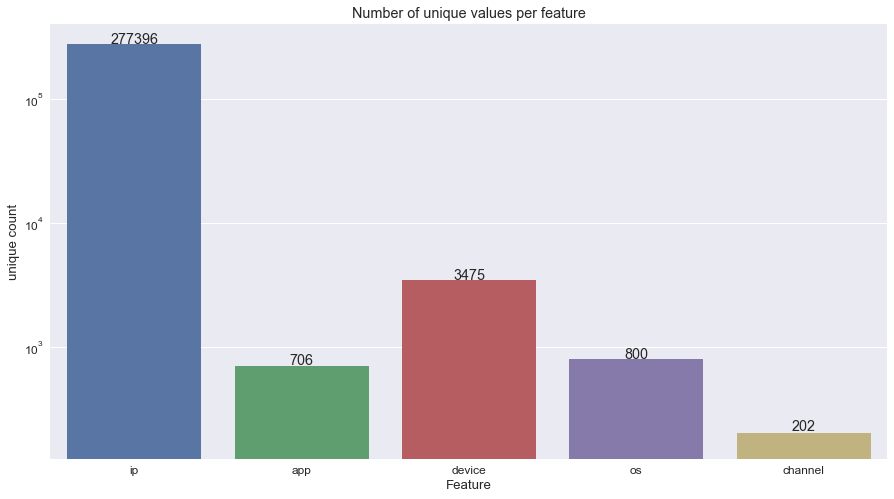

In [16]:
# 전체 row 갯수는 184,903,890개 (1억 8천4백9십만 3천8백9십)
# ip : 277,396개 
# app : 706개
# device : 3,475개
# os : 800 개
plt.figure(figsize=(15, 8))
cols = ['ip', 'app', 'device', 'os', 'channel']
uniques = [len(train[col].unique()) for col in cols]
sns.set(font_scale=1.2)
ax = sns.barplot(cols, uniques, palette = color, log = True)
ax.set(xlabel='Feature', ylabel='unique count', title='Number of unique values per feature')
for p, uniq in zip(ax.patches, uniques):
    height = p.get_height()
    ax.text(p.get_x() + p.get_width()/2.,
            height + 10,s
            uniq,
            ha="center") 

### app

In [70]:
# is_attributed 가 1인 ip 의 평균 app 사용 개수 
trainGroup = []
trainGroup = train[train.is_attributed == 1].groupby(['ip'])['app'].nunique().reset_index(name='n')
max_value = np.max(trainGroup.n)
min_value = np.min(trainGroup.n)
mean_value = round(np.mean(trainGroup.n), 2)
qrange = [0.99, 0.95, 0.90, 0.8, 0.7, 0.5, 0.3]
result = []
for value in qrange:
    result.append(trainGroup.n.quantile(value))

print("상위 1% '{}': | 상위 5% '{}': | 상위 10%: {} | 상위 20%: {} | 상위 30%: {} | 상위 50%: {} |  상위 70%: {} | 최대값: {} | 최소값: {} | 평균값: {}".format(*result, max_value, min_value, mean_value))

상위 1% '7.0': | 상위 5% '3.0': | 상위 10%: 2.0 | 상위 20%: 1.0 | 상위 30%: 1.0 | 상위 50%: 1.0 |  상위 70%: 1.0 | 최대값: 86 | 최소값: 1 | 평균값: 1.3574180331213934


In [71]:
# is_attributed 가 0인 ip 의 평균 app 사용 개수 
trainGroup = []
trainGroup = train[train.is_attributed == 0].groupby(['ip'])['app'].nunique().reset_index(name='n')
max_value = np.max(trainGroup.n)
min_value = np.min(trainGroup.n)
mean_value = round(np.mean(trainGroup.n), 2)
qrange = [0.99, 0.95, 0.90, 0.8, 0.7, 0.5, 0.3]
result = []
for value in qrange:
    result.append(trainGroup.n.quantile(value))

print("상위 1% '{}': | 상위 5% '{}': | 상위 10%: {} | 상위 20%: {} | 상위 30%: {} | 상위 50%: {} |  상위 70%: {} | 최대값: {} | 최소값: {} | 평균값: {}".format(*result, max_value, min_value, mean_value))

상위 1% '64.0': | 상위 5% '46.0': | 상위 10%: 38.0 | 상위 20%: 28.0 | 상위 30%: 20.0 | 상위 50%: 9.0 |  상위 70%: 4.0 | 최대값: 247 | 최소값: 1 | 평균값: 15.225170148949367


In [73]:
# app 상위 10개 
train.groupby('app').size().sort_values(ascending = False).head(n = 10)

app
3     33911780
12    24179003
2     21642136
9     16458268
15    15958970
18    15756587
14    10027169
1      5796274
13     4329409
8      3731948
dtype: int64

In [ ]:
# is_attributed == 1 app 상위 10개
# 19, 35, 29, 10, 5, 45, 72 등등 순위가 높음
# 3, 9, 18 은 오히려 순위 하락
train[train.is_attributed == 1].groupby('app').size().sort_values(ascending = False).head(n = 10)

app
19    132390
35     64279
29     39957
10     34578
5      27263
9      18823
45     16307
72     11443
3      10261
18      7919
dtype: int64

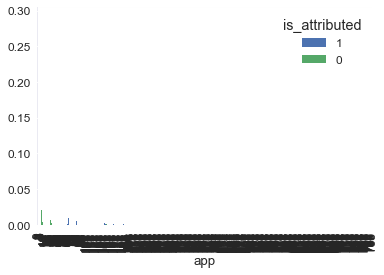

In [78]:
plt.figure(figsize=(15, 8))
app = train.groupby(['app', 'is_attributed'])['app'].count().unstack('is_attributed')
app /= app.sum()
app[[1, 0]].plot(kind = 'bar')
plt.show()

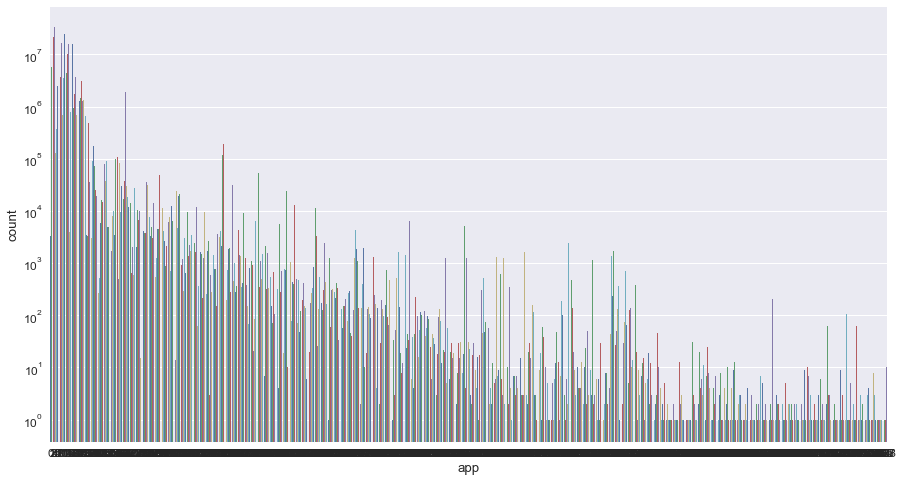

In [76]:
plt.figure(figsize=(15, 8))
sns.countplot(x = 'app', data = train, palette = color, log = True)
plt.show()

In [91]:
app1 = train.groupby(['app', 'is_attributed'])['ip'].nunique().reset_index(name='count')
appAll = train.groupby(['app'])['ip'].nunique().reset_index(name='total')
app1Join= app1.join(appAll.set_index('app'), on='app')

In [93]:
app1Join['ratio'] = app1Join['count'] / app1Join['total']

In [107]:
# app 별 is attirbuted 비율 
app1Join[(app1Join.is_attributed == 1) & (app1Join.ratio < 1)].sort_values(by = "ratio",ascending = False).head(n = 20)

/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,app,is_attributed,count,total,ratio
195,116,1,597,633,0.943128
764,618,1,7,8,0.875000
376,246,1,207,238,0.869748
69,35,1,29610,35019,0.845541
39,19,1,99506,128919,0.771849
334,214,1,257,333,0.771772
530,364,1,3,4,0.750000
146,84,1,2587,3472,0.745104
550,383,1,14,19,0.736842
345,223,1,77,105,0.733333


In [110]:
# app 별 is_attributed 비율 평균 
app1Join[app1Join.is_attributed == 1].ratio.mean()

0.2803369763751778

In [114]:
# app 별 is_attirbuted 비율 분포 
temp = []
temp = app1Join[app1Join.is_attributed == 1].ratio
max_value = round(np.max(temp), 2)
min_value = round(np.min(temp), 2)
mean_value = round(np.mean(temp), 2)
qrange = [0.99, 0.95, 0.90, 0.8, 0.75, 0.5, 0.3]
result = []
for value in qrange:
    result.append(round(temp.quantile(value),2))

print("상위 1% '{}': | 상위 5% '{}': | 상위 10%: {} | 상위 20%: {} | 상위 30%: {} | 상위 50%: {} |  상위 75%: {} | 최대값: {} | 최소값: {} | 평균값: {}".format(*result, max_value, min_value, mean_value))

상위 1% '1.0': | 상위 5% '1.0': | 상위 10%: 0.74 | 상위 20%: 0.5 | 상위 30%: 0.47 | 상위 50%: 0.18 |  상위 75%: 0.04 | 최대값: 1.0 | 최소값: 0.0 | 평균값: 0.28


### device

In [119]:
# is_attributed 가 1인 ip 의 평균 device 사용 개수 
temp = []
temp = train[train.is_attributed == 1].groupby(['ip'])['device'].nunique().reset_index(name='n')
max_value = round(np.max(temp.n), 2)
min_value = round(np.min(temp.n), 2)
mean_value = round(np.mean(temp.n), 2)
qrange = [0.99, 0.95, 0.90, 0.8, 0.75, 0.5, 0.3]
result = []
for value in qrange:
    result.append(round(temp.n.quantile(value),2))

print("상위 1% '{}': | 상위 5% '{}': | 상위 10%: {} | 상위 20%: {} | 상위 30%: {} | 상위 50%: {} |  상위 75%: {} | 최대값: {} | 최소값: {} | 평균값: {}".format(*result, max_value, min_value, mean_value))

상위 1% '3.0': | 상위 5% '2.0': | 상위 10%: 1.0 | 상위 20%: 1.0 | 상위 30%: 1.0 | 상위 50%: 1.0 |  상위 75%: 1.0 | 최대값: 115 | 최소값: 1 | 평균값: 1.14


In [121]:
# is_attributed 가 0인 ip 의 평균 device 사용 개수 
temp = []
temp = train[train.is_attributed == 0].groupby(['ip'])['device'].nunique().reset_index(name='n')
max_value = round(np.max(temp.n), 2)
min_value = round(np.min(temp.n), 2)
mean_value = round(np.mean(temp.n), 2)
qrange = [0.99, 0.95, 0.90, 0.8, 0.75, 0.5, 0.3]
result = []
for value in qrange:
    result.append(round(temp.n.quantile(value),2))

print("상위 1% '{}': | 상위 5% '{}': | 상위 10%: {} | 상위 20%: {} | 상위 30%: {} | 상위 50%: {} |  상위 75%: {} | 최대값: {} | 최소값: {} | 평균값: {}".format(*result, max_value, min_value, mean_value))

상위 1% '15.0': | 상위 5% '8.0': | 상위 10%: 5.0 | 상위 20%: 3.0 | 상위 30%: 3.0 | 상위 50%: 1.0 |  상위 75%: 1.0 | 최대값: 441 | 최소값: 1 | 평균값: 2.56


### os

In [122]:
# is_attributed 가 1인 ip 의 평균 os 사용 개수 
temp = []
temp = train[train.is_attributed == 1].groupby(['ip'])['os'].nunique().reset_index(name='n')
max_value = round(np.max(temp.n), 2)
min_value = round(np.min(temp.n), 2)
mean_value = round(np.mean(temp.n), 2)
qrange = [0.99, 0.95, 0.90, 0.8, 0.75, 0.5, 0.3]
result = []
for value in qrange:
    result.append(round(temp.n.quantile(value),2))

print("상위 1% '{}': | 상위 5% '{}': | 상위 10%: {} | 상위 20%: {} | 상위 30%: {} | 상위 50%: {} |  상위 75%: {} | 최대값: {} | 최소값: {} | 평균값: {}".format(*result, max_value, min_value, mean_value))

상위 1% '8.0': | 상위 5% '4.0': | 상위 10%: 3.0 | 상위 20%: 1.0 | 상위 30%: 1.0 | 상위 50%: 1.0 |  상위 75%: 1.0 | 최대값: 57 | 최소값: 1 | 평균값: 1.48


In [123]:
# is_attributed 가 0인 ip 의 평균 os 사용 개수 
temp = []
temp = train[train.is_attributed == 0].groupby(['ip'])['os'].nunique().reset_index(name='n')
max_value = round(np.max(temp.n), 2)
min_value = round(np.min(temp.n), 2)
mean_value = round(np.mean(temp.n), 2)
qrange = [0.99, 0.95, 0.90, 0.8, 0.75, 0.5, 0.3]
result = []
for value in qrange:
    result.append(round(temp.n.quantile(value),2))

print("상위 1% '{}': | 상위 5% '{}': | 상위 10%: {} | 상위 20%: {} | 상위 30%: {} | 상위 50%: {} |  상위 75%: {} | 최대값: {} | 최소값: {} | 평균값: {}".format(*result, max_value, min_value, mean_value))

상위 1% '63.0': | 상위 5% '48.0': | 상위 10%: 40.0 | 상위 20%: 24.0 | 상위 30%: 18.0 | 상위 50%: 3.0 |  상위 75%: 2.0 | 최대값: 187 | 최소값: 1 | 평균값: 12.1


### channel

In [124]:
# is_attributed 가 1인 ip 의 평균 chaanel 사용 개수 
temp = []
temp = train[train.is_attributed == 1].groupby(['ip'])['channel'].nunique().reset_index(name='n')
max_value = round(np.max(temp.n), 2)
min_value = round(np.min(temp.n), 2)
mean_value = round(np.mean(temp.n), 2)
qrange = [0.99, 0.95, 0.90, 0.8, 0.75, 0.5, 0.3]
result = []
for value in qrange:
    result.append(round(temp.n.quantile(value),2))

print("상위 1% '{}': | 상위 5% '{}': | 상위 10%: {} | 상위 20%: {} | 상위 30%: {} | 상위 50%: {} |  상위 75%: {} | 최대값: {} | 최소값: {} | 평균값: {}".format(*result, max_value, min_value, mean_value))

상위 1% '8.0': | 상위 5% '3.0': | 상위 10%: 2.0 | 상위 20%: 1.0 | 상위 30%: 1.0 | 상위 50%: 1.0 |  상위 75%: 1.0 | 최대값: 90 | 최소값: 1 | 평균값: 1.38


In [125]:
# is_attributed 가 0인 ip 의 평균 channel 사용 개수 
temp = []
temp = train[train.is_attributed == 0].groupby(['ip'])['channel'].nunique().reset_index(name='n')
max_value = round(np.max(temp.n), 2)
min_value = round(np.min(temp.n), 2)
mean_value = round(np.mean(temp.n), 2)
qrange = [0.99, 0.95, 0.90, 0.8, 0.75, 0.5, 0.3]
result = []
for value in qrange:
    result.append(round(temp.n.quantile(value),2))

print("상위 1% '{}': | 상위 5% '{}': | 상위 10%: {} | 상위 20%: {} | 상위 30%: {} | 상위 50%: {} |  상위 75%: {} | 최대값: {} | 최소값: {} | 평균값: {}".format(*result, max_value, min_value, mean_value))

상위 1% '125.0': | 상위 5% '107.0': | 상위 10%: 96.0 | 상위 20%: 74.0 | 상위 30%: 62.0 | 상위 50%: 12.0 |  상위 75%: 4.0 | 최대값: 162 | 최소값: 1 | 평균값: 32.27


### app X channel

In [159]:
# app 별 is_attributed가 평균 비율보다 높은 것만
appList = app1Join[(app1Join.is_attributed == 1) & (app1Join.ratio > 0.5) & (app1Join.ratio < 1)].app.unique()

In [ ]:
# app중 is_attributed가 높은 것 중에서 주요 어느채널을이 많은지!
# 필터 후 app별 channel별 unique한 ip갯수 
appTemp = train[(train.is_attributed == 1) & (train.isin({'app': appList}))]
appTemp = appTemp.groupby(['app', 'channel'])['ip'].nunique().reset_index(name='count')
appTemp.sort_values(by = "count", ascending = False)

### click time

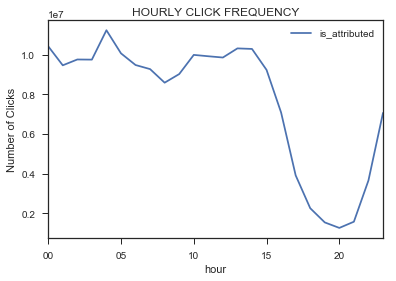

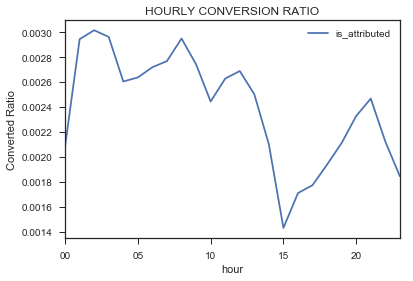

In [150]:
# plt size 
plt.figure(figsize=(15, 8))

# click frequency
train[['hour','is_attributed']].groupby(['hour'], as_index=True).count().plot()
plt.title('HOURLY CLICK FREQUENCY');
plt.ylabel('Number of Clicks');

# conversion ratio
train[['hour','is_attributed']].groupby(['hour'], as_index=True).mean().plot()
plt.title('HOURLY CONVERSION RATIO');
plt.ylabel('Converted Ratio');

In [ ]:
# train['user_id'] = "{}-{}-{}".format(train['ip'], train['os'], train['device'])

In [ ]:
# is_attributed 가 1인 ip 의 평균 app 사용 개수 
trainGroup = []
trainGroup = train[train.is_attributed == 1].groupby(['user_id'])['app'].nunique().reset_index(name='n')
max_value = np.max(trainGroup.n)
min_value = np.min(trainGroup.n)
mean_value = round(np.mean(trainGroup.n), 2)
qrange = [0.99, 0.95, 0.90, 0.8, 0.7, 0.5, 0.3]
result = []
for value in qrange:
    result.append(trainGroup.n.quantile(value))

print("상위 1% '{}': | 상위 5% '{}': | 상위 10%: {} | 상위 20%: {} | 상위 30%: {} | 상위 50%: {} |  상위 70%: {} | 최대값: {} | 최소값: {} | 평균값: {}".format(*result, max_value, min_value, mean_value))

In [ ]:
# is_attributed 가 1인 ip 의 평균 app 사용 개수 
trainGroup = []
trainGroup = train[train.is_attributed == 1].groupby(['user_id'])['app'].nunique().reset_index(name='n')
max_value = np.max(trainGroup.n)
min_value = np.min(trainGroup.n)
mean_value = round(np.mean(trainGroup.n), 2)
qrange = [0.99, 0.95, 0.90, 0.8, 0.7, 0.5, 0.3]
result = []
for value in qrange:
    result.append(trainGroup.n.quantile(value))

print("상위 1% '{}': | 상위 5% '{}': | 상위 10%: {} | 상위 20%: {} | 상위 30%: {} | 상위 50%: {} |  상위 70%: {} | 최대값: {} | 최소값: {} | 평균값: {}".format(*result, max_value, min_value, mean_value))